In [1]:
using Gadfly, DataFrames

In [2]:
function imitate(nodes::Int, prob::Float64, moved::Int)
    tot = 0
    for i in 1:(nodes - moved)
        for j in 1:moved
            if prob > rand() 
                tot = tot + 1 
                break
            end 
        end
    end
    tot
end

imitate (generic function with 1 method)

Suppose we have $n$ nodes and $m$ moved. We wish to determine how many nodes will imitate at least one of the $m$ nodes and move themselves. Each node will imitate with probability $p$. The number of nodes available to imitate is $k = n - m$. We can think of each of these $k$ nodes as having $m$ chances to imitate a node that moved:

\begin{equation*}
  X \sim\binom{m}{x}p^x(1-p)^{m-x}
\end{equation*}

A node moves if it imitated at least one of the other nodes:

\begin{equation*}
  P(X \geq 1) = 1 - P(X < 1) = 1 - (1-p)^m = z
\end{equation*}

where $z$ is the probability a node moves. The distribution representing the probability that $v$ nodes move is given by:

\begin{equation*}
    V \sim \binom{k}{v}z^v(1-z)^{k-v}
\end{equation*}

Thus we can determine the expected number of nodes that will move:

\begin{equation}
  \langle V \rangle = k - k(1 - p)^m
  \label{eq:expv}
\end{equation}


In [3]:
function expectedMoves(n::Int, p::Float64, m::Int)
    k = n - m
    k - k * (1 - p)^m
end

expectedMoves (generic function with 1 method)

In [4]:
function expectedMovesSim(n::Int, p::Float64, m::Int, trials::Int)
    im = 0
    for i in 1:trials
        im = im + imitate(n, p, m)
    end
    im / trials
end

expectedMovesSim (generic function with 1 method)

In [5]:
n = 10
p = .5
m = 5
expectedMoves(n, p, m)

4.84375

In [6]:
expectedMovesSim(n, p, m, 10^6)

4.843572

In [7]:
function catalyze(nodes::Int, prob::Float64, moved::Int, limit::Int = 10^4; force = true)
    record = [1]
    itr = 1
    while moved > 0 && itr < limit
        moved = imitate(nodes, prob, moved)
        push!(record, moved)
        if force && moved == 0
            moved = 1
        end
        itr = itr + 1
    end
    record
end

catalyze (generic function with 2 methods)

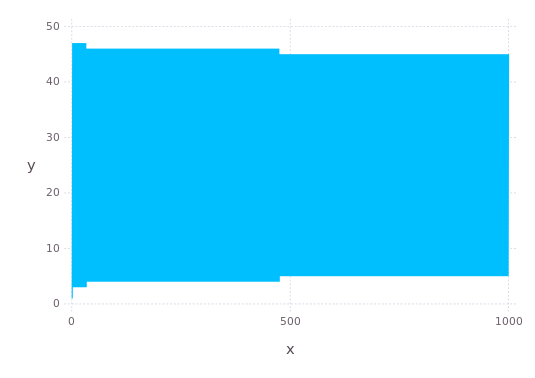

In [31]:
record = catalyze(50, .9, 3, 10^3, force = false);
mean(record);
plot(x = [x for x = 1:length(record)], y = record, Geom.line)

In [9]:
function expectedrec(n::Int, p::Float64, x::Float64, a::Array{Float64, 1}, i::Int, limit::Int = 10^4)
    print("|",i)
    if i > limit
        a = expectedrec(n, p, x, a, i))
    end
    i = i + 1 
end

LoadError: LoadError: syntax: extra token ")" after end of expression
while loading In[9], in expression starting on line 4

In [10]:
a = Array{Float64, 1}()
expectedrec(3, 1/2, 1.0, a, 1)

LoadError: LoadError: UndefVarError: expectedrec not defined
while loading In[10], in expression starting on line 2

In [11]:
a = Array{Float64, 1}()
push!(a, 1)

1-element Array{Float64,1}:
 1.0

In [12]:
function simulate(folds::Int, totalnodes::Int, numprobs::Int, probstop::Float64)
    analysisnodes::Int = totalnodes - 1
    allmoves = Array{Float64}(analysisnodes, numprobs)
    alltime = Array{Float64}(analysisnodes, numprobs)
    probs = linspace(.01, probstop, numprobs)
    a = 1
    for p in probs, i in 2:totalnodes
        avgmoves = 0
        avgtime = 0
        for j in 1:folds
            record = catalyze(i, p, 1)
            avgmoves = avgmoves + (mean(record))
            avgtime = avgtime + length(record)
        end
        allmoves[a] = avgmoves / folds
        alltime[a] = avgtime / folds
        #print("|$i, $p: $(allmoves[a])")
        a = a + 1
    end
    (allmoves, alltime)
end

simulate (generic function with 1 method)

In [13]:
folds = 10
nodes = 30 
probs = 10
probstop = .99
probvalues = linspace(.01, probstop, probs)
(moves, time) = simulate(folds, nodes, probs, probstop);

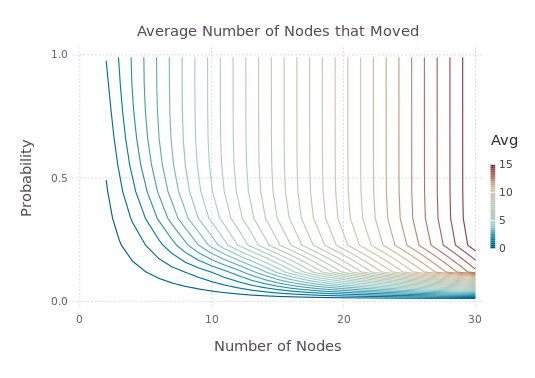

In [14]:
plot(z = moves, x = [x for x = 2:nodes], y = [x for x in probvalues],
Geom.contour(levels=30), Guide.xlabel("Number of Nodes"), Guide.ylabel("Probability"),
Guide.title("Average Number of Nodes that Moved"), Guide.colorkey("Avg"))

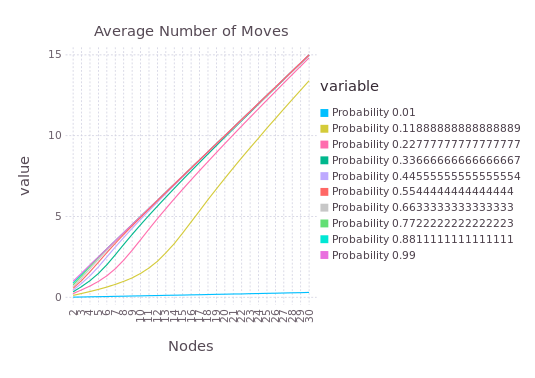

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 in anonymous at no file
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/cfusting/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/cfusting/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[15], in expression starting on line 2


In [15]:
data = DataFrame([2:nodes moves])
names!(data, convert(Array{Symbol, 1}, ["Nodes", [symbol("Probability $x") for x in probvalues]]))
dat = stack(data, [2:probs + 1]);
plot(dat, x = "Nodes", y = "value", color = "variable", Geom.line,
Guide.title("Average Number of Moves"), Stat.xticks(ticks = [x for x = 2:nodes]))